<a href="https://colab.research.google.com/github/kate-melnykova/BCdata2018-SNC-Lavalin-project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigating one ship case

### run DataCleaning-final.ipynb first

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
%matplotlib inline

from os import path, getcwd
from glob import glob
import pykalman
import datetime as dt
from pykalman import KalmanFilter

In [ ]:
delta_cur = pd.read_csv('./delta_cur_processed.csv',parse_dates =['ReceivedTime'])

In [ ]:
delta_cur = delta_cur.drop(['Unnamed: 0'],axis=1)
delta_cur.head()

,UserID,ROT,SOG,Longitude,Latitude,TrueHeading,ReceivedTime,Time2,Speed_long,Speed_lat,PathID
0,209817000,0.0,11.1,-123.20550,48.40427,35.0,2013-10-28 17:46:25.417,1382982480,-0.106112,-0.151543,1
1,209817000,0.0,11.3,-123.19783,48.41012,35.0,2013-10-28 17:48:55.293,1382982480,-0.108024,-0.154274,1
2,209817000,0.0,11.3,-123.19692,48.41083,35.0,2013-10-28 17:49:13.887,1382982480,-0.108024,-0.154274,1
3,209817000,0.0,11.3,-123.19635,48.41127,34.0,2013-10-28 17:49:25.670,1382982480,-0.105315,-0.156135,1
4,209817000,0.0,11.3,-123.19525,48.41210,31.0,2013-10-28 17:49:45.623,1382982480,-0.096999,-0.161433,1


In [ ]:
user_ID_allowed = np.unique(delta_cur['UserID'])
# As the first try, we choose one ship only
UserID = list(user_ID_allowed)[25]

In [ ]:
df = delta_cur[delta_cur['UserID']==UserID] #select the single ship
df = df.drop(['UserID'],axis=1)
df = df.sort_values(by=['Time2']).reset_index(drop=True) #sort entries by Time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046 entries, 0 to 1045
Data columns (total 10 columns):
ROT             1046 non-null float64
SOG             1046 non-null float64
Longitude       1046 non-null float64
Latitude        1046 non-null float64
TrueHeading     1046 non-null float64
ReceivedTime    1046 non-null datetime64[ns]
Time2           1046 non-null int64
Speed_long      1046 non-null float64
Speed_lat       1046 non-null float64
PathID          1046 non-null int64
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 81.8 KB


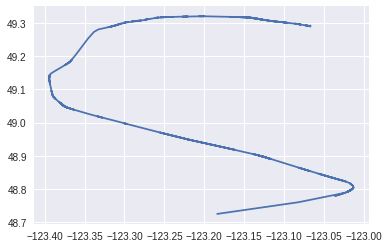

In [ ]:
plt.plot(df['Longitude'],df['Latitude'])

In [ ]:
#plot all data
m = folium.Map(location=[49, -123.7], 
               tiles='Stamen Terrain', zoom_start=9)
latlon = zip(df.Latitude.values, 
             df.Longitude.values)
for coord in latlon:
    folium.Circle(location=coord, fill=True,radius=7,color='red').add_to(m)

In [ ]:
m

In [ ]:
#group by time (timedelta = 6 minutes) and compute mean location, ROT, SOG and TrueHeading
def compute_mean(df_t):
    row = pd.Series()
    for key in df_t.keys():
        if key!='ReceivedTime':
            row[key] = np.mean(df_t[key])
    return row

def process_df(df):
    col_names = df.columns.values.tolist()
    col_names.remove('ReceivedTime')
    df_new = pd.DataFrame(columns = col_names)
    idx = 0 #next index in df_new to be written at
    min_time = np.min(df['Time2'])
    max_time = np.max(df['Time2'])
    pathID = df.loc[0,'PathID']
    for t in range(min_time,max_time+360,360):
        mask = (df['Time2'] == t)
        if np.sum(mask)>0.5: #there is at least one entry
            df_new.loc[idx] = compute_mean(df[mask])
        else:
            df_new.loc[idx] = np.nan
            df_new.loc[idx,'Time2'] = t
            df_new.loc[idx,'PathID'] = pathID
        idx = idx + 1
    return df_new

In [ ]:
df_new = process_df(df)
#The data is ready for approximating paths

In [ ]:
df_new.tail()

,ROT,SOG,Longitude,Latitude,TrueHeading,Time2,Speed_long,Speed_lat,PathID
149,NaN,NaN,NaN,NaN,NaN,1.382458e+09,NaN,NaN,1.0
150,0.0,12.500000,-123.08254,48.760060,240.000000,1.382459e+09,0.180422,0.104167,1.0
151,NaN,NaN,NaN,NaN,NaN,1.382459e+09,NaN,NaN,1.0
152,NaN,NaN,NaN,NaN,NaN,1.382459e+09,NaN,NaN,1.0
153,0.0,13.566667,-123.17193,48.729207,240.666667,1.382460e+09,0.197050,0.110690,1.0


In [ ]:
df_new.head()

,ROT,SOG,Longitude,Latitude,TrueHeading,Time2,Speed_long,Speed_lat,PathID
0,0.0,0.0,-123.06751,49.28934,181.0,1.382405e+09,0.0,0.0,1.0
1,0.0,0.0,-123.06751,49.28934,181.0,1.382405e+09,0.0,0.0,1.0
2,0.0,0.0,-123.06753,49.28933,181.0,1.382405e+09,0.0,0.0,1.0
3,0.0,0.0,-123.06751,49.28932,181.0,1.382406e+09,0.0,0.0,1.0
4,0.0,0.0,-123.06753,49.28935,181.0,1.382406e+09,0.0,0.0,1.0


In [ ]:
#to feed the data to pykalman we need to mask NaN values
def preprocess_kalman(columns,df_new):
    """
    columns: columns used for pykalman
    df_new: dataframe to process
    """
    mask = df_new[columns].isnull()
    measurements = np.ma.array(np.array(df_new[columns]),mask=mask)
    return measurements
meas = preprocess_kalman(['Longitude','Latitude','Speed_long','Speed_lat'],df_new)
print(meas[:5,:])

[[-123.06751 49.28934 0.0 0.0]
 [-123.06751 49.28934 0.0 0.0]
 [-123.06753 49.28933 0.0 0.0]
 [-123.06751 49.28932 0.0 0.0]
 [-123.06753 49.28935 0.0 0.0]]


In [ ]:
# True state model
#(x,y,x',y',x'',y'')
from pykalman import KalmanFilter
deltaT = (6/60) #convert minutes to hours
#general formula
#x_new = x + x_vel*deltaT+x_acc*detlaT^2/2
#vel_new = vel + acc*deltaT
#acc_new ~ acc
transition_matrix = np.eye(6)
transition_matrix[0,2] = deltaT
transition_matrix[0,4] = deltaT**2/2
transition_matrix[1,3] = deltaT
transition_matrix[1,5] = deltaT**2/2
transition_matrix[2,4] = deltaT
transition_matrix[3,5] = deltaT
print('Transition matrix')
print(transition_matrix)
observation_matrix= np.zeros((4,6))
observation_matrix[:4,:4] = np.eye(4)
print('Observation matrix')
print(observation_matrix)

Transition matrix
[[ 1.     0.     0.1    0.     0.005  0.   ]
 [ 0.     1.     0.     0.1    0.     0.005]
 [ 0.     0.     1.     0.     0.1    0.   ]
 [ 0.     0.     0.     1.     0.     0.1  ]
 [ 0.     0.     0.     0.     1.     0.   ]
 [ 0.     0.     0.     0.     0.     1.   ]]
Observation matrix
[[ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]]


In [ ]:
initial_state = (df_new.loc[0,'Longitude'],
                df_new.loc[0,'Latitude'],
                df_new.loc[0,'Speed_long'],
                df_new.loc[0,'Speed_lat'],
                0,0)
kf = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean=initial_state)

kf = kf.em(meas, n_iter=10)

(filtered_state_means, filtered_state_covariances) = kf.filter(meas)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(meas)

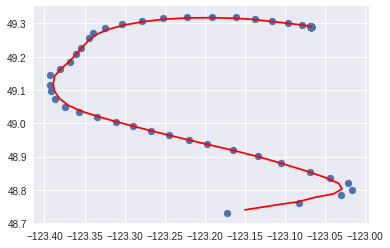

In [ ]:
view = df_new[['Latitude','Longitude']].dropna(axis=0)
plt.plot()
plt.scatter(view['Longitude'],view['Latitude'])
plt.plot(smoothed_state_means[:,0],smoothed_state_means[:,1],color='red')
#plt.scatter(smoothed_state_means[-1:,1],smoothed_state_means[-1:,0],color='green')

In [ ]:
m = folium.Map(location=[49, -123.7], 
               tiles='Stamen Terrain', zoom_start=9)
latlon = zip(view.Latitude.values, view.Longitude.values)
for coord in latlon:
    folium.Circle(location=coord, fill=True,color='red',radius=7).add_to(m)
paths = [tuple((a,b)) for a, b in zip(list(smoothed_state_means[:,1]),list(smoothed_state_means[:,0]))]
folium.PolyLine(paths,color ='blue').add_to(m)

In [ ]:
m

# Check perfomance on historical data - more sparse

## Pre-process the data

In [ ]:
delta_hist = pd.read_csv('delta_hist_processed.csv',
                         usecols=['UserID', 'Longitude', 'Latitude',
                                  'ReceivedTime', 'Time2', 'Speed_long', 'Speed_lat',
                                  'PathID'])

In [ ]:
delta_hist.head()

,UserID,Longitude,Latitude,ReceivedTime,Time2,Speed_long,Speed_lat,PathID
0,1193046,-123.02485,49.26383,2013-08-13 11:19:23.623,1376392680,-0.0,0.0,1
1,1193046,-123.02482,49.26388,2013-08-15 10:15:13.680,1376561880,-0.0,0.0,2
2,1193046,-123.02485,49.26377,2013-08-16 09:23:08.763,1376645040,-0.0,0.0,3
3,1193046,-123.02488,49.26383,2013-08-16 09:30:16.873,1376645400,-0.0,0.0,3
4,1193046,-123.02488,49.26387,2013-08-16 09:44:23.590,1376646120,-0.0,0.0,3


In [ ]:
delta_hist['UserID'].value_counts()

316011982    23346
316013397    23020
316021351    22987
316005727    22869
316005845    22520
316014621    22519
316005624    22261
316001268    22161
316020871    22125
316001255    21987
316009842    21685
316014995    21566
316005625    21139
316020869    20394
316005723    20289
316003667    20093
316020868    19878
316005621    18961
316009547    18915
316005721    18905
316001221    18849
316005726    18800
316013198    17879
316004333    17526
316023452    17458
316018851    17412
316001245    17117
316001269    16078
316012751    15853
316005623    15518
             ...  
317117910        1
367505480        1
89016140         1
316018038        1
367567760        1
273350370        1
355029000        1
317054292        1
338094155        1
367411490        1
368388000        1
319056200        1
316065536        1
244730638        1
367503470        1
367524610        1
517341213        1
316019467        1
316017604        1
366978690        1
338124984        1
367122760   

In [ ]:
#select a ship
ship_list = np.unique(delta_hist['UserID'])
UserID = 316005623
print('UserID', UserID)
path_no = 4

UserID 316005623


In [ ]:
df = delta_hist[(delta_hist['UserID']==UserID)&(delta_hist['PathID']==path_no)] #select the single ship
df = df.drop(['UserID'],axis=1)
df = df.sort_values(by=['Time2']).reset_index(drop=True) #sort entries by Time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 7 columns):
Longitude       152 non-null float64
Latitude        152 non-null float64
ReceivedTime    152 non-null object
Time2           152 non-null int64
Speed_long      152 non-null float64
Speed_lat       152 non-null float64
PathID          152 non-null int64
dtypes: float64(4), int64(2), object(1)
memory usage: 8.4+ KB


In [ ]:
meas = preprocess_kalman(['Longitude','Latitude','Speed_long','Speed_lat'],df)
print(meas[:12,:])

[[-123.06072 49.29076 -0.0 0.0]
 [-123.06076000000002 49.29074 -0.0 0.0]
 [-123.06076000000002 49.29068 -0.0 0.0]
 [-123.06071 49.29068 -0.0 0.0]
 [-123.06074 49.29074 -0.0 0.0]
 [-123.06073 49.29078 -0.0 0.0]
 [-123.06073 49.2908 -0.0 0.0]
 [-123.06074 49.29074 -0.0 0.0]
 [-123.06076000000002 49.29079 -0.0 0.0]
 [-123.06074 49.29071 -0.0 0.0]
 [-123.06076000000002 49.29077 -0.0 0.0]
 [-123.06075 49.29077 -0.0 0.0]]


In [ ]:
# True state model
#(x,y,x',y',x'',y'')
from pykalman import KalmanFilter
deltaT = 6/60 #convert minutes to hours
#general formula
#x_new = x + x_vel*deltaT+x_acc*detlaT^2/2
#vel_new = vel + acc*deltaT
#acc_new ~ acc
transition_matrix = np.eye(6)
transition_matrix[0,2] = deltaT
transition_matrix[0,4] = deltaT**2/2
transition_matrix[1,3] = deltaT
transition_matrix[1,5] = deltaT**2/2
transition_matrix[2,4] = deltaT
transition_matrix[3,5] = deltaT
print('Transition matrix')
print(transition_matrix)
observation_matrix= np.zeros((4,6))
observation_matrix[:4,:4] = np.eye(4)
print('Observation matrix')
print(observation_matrix)

Transition matrix
[[ 1.     0.     0.1    0.     0.005  0.   ]
 [ 0.     1.     0.     0.1    0.     0.005]
 [ 0.     0.     1.     0.     0.1    0.   ]
 [ 0.     0.     0.     1.     0.     0.1  ]
 [ 0.     0.     0.     0.     1.     0.   ]
 [ 0.     0.     0.     0.     0.     1.   ]]
Observation matrix
[[ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]]


In [ ]:
# ['Longitude','Latitude','Speed_x','Speed_y']
initial_state = (df.loc[0,'Longitude'],
                df.loc[0,'Latitude'],
                df.loc[0,'Speed_long'],
                df.loc[0,'Speed_lat'],
                0,0)
print(initial_state)
kf = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean=initial_state)

kf = kf.em(meas, n_iter=5)

(filtered_state_means, filtered_state_covariances) = kf.filter(meas)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(meas)

(-123.06072, 49.290759999999999, -0.0, 0.0, 0, 0)


In [ ]:
meas[0,:]

masked_array(data = [-123.06072 49.29076 -0.0 0.0],
             mask = [False False False False],
       fill_value = 1e+20)

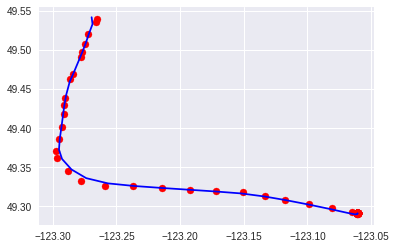

In [ ]:
view = df[['Latitude','Longitude']].dropna(axis=0)
plt.plot()
plt.scatter(view['Longitude'],view['Latitude'],color='red')
plt.plot(smoothed_state_means[:,0],smoothed_state_means[:,1],color='blue')
#plt.scatter(smoothed_state_means[:,1],smoothed_state_means[:,0],color='green')

In [ ]:
m = folium.Map(location=[np.mean(view.Latitude.values.tolist()), np.mean(view.Longitude.values.tolist())], 
               tiles='Stamen Terrain', zoom_start=9)
latlon = zip(view.Latitude.values, view.Longitude.values)
for coord in latlon:
    folium.Circle(location=coord, fill=True,color='red',radius=7).add_to(m)
paths = [tuple((a,b)) for a, b in zip(list(smoothed_state_means[:,1]),list(smoothed_state_means[:,0]))]
folium.PolyLine(paths,color ='blue').add_to(m)

In [ ]:
m